<a href="https://colab.research.google.com/github/jacobpad/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

#################
# I Think This Is Where I Start
#################

# Imports

In [0]:
# A bunch of imports, yes, it's probably overkill
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import plotly.express as px
import category_encoders as ce
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_regression
%matplotlib inline
# import and manipulate datetime
import datetime

# Check it out

In [0]:
#  Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [7]:
# What am I looking at?
df.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040.000000,23040.000000,0.0,23039.000000,23039.000000,23039.000000,23039.000000,2.303900e+04,23005.000000,23040.000000,2.304000e+04
mean,4459.116493,353.948481,NaN,10791.186987,1.827423,0.286514,2.320891,3.508555e+03,1819.671724,1.624479,1.328133e+06
std,3713.269887,628.025255,NaN,1103.414210,10.090432,5.778224,12.070554,2.218610e+04,488.376571,0.803898,1.025394e+07
min,1.000000,1.000000,NaN,0.000000,0.000000,-148.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,1341.000000,22.000000,NaN,10306.000000,0.000000,0.000000,1.000000,4.940000e+02,1920.000000,1.000000,0.000000e+00
50%,3546.000000,49.000000,NaN,11211.000000,1.000000,0.000000,1.000000,1.356000e+03,1940.000000,1.000000,4.550000e+05
75%,6673.750000,375.000000,NaN,11360.000000,2.000000,0.000000,2.000000,2.280000e+03,1965.000000,2.000000,8.750000e+05
max,16350.000000,9057.000000,NaN,11697.000000,750.000000,570.000000,755.000000,1.303935e+06,2019.000000,4.000000,8.500000e+08


In [8]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [9]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [10]:
df['BUILDING_CLASS_CATEGORY'].unique()

array(['13 CONDOS - ELEVATOR APARTMENTS', '21 OFFICE BUILDINGS',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL',
       '07 RENTALS - WALKUP APARTMENTS', '01 ONE FAMILY DWELLINGS',
       '02 TWO FAMILY DWELLINGS', '05 TAX CLASS 1 VACANT LAND',
       '29 COMMERCIAL GARAGES', '32 HOSPITAL AND HEALTH FACILITIES',
       '33 EDUCATIONAL FACILITIES', '08 RENTALS - ELEVATOR APARTMENTS',
       '31 COMMERCIAL VACANT LAND', '41 TAX CLASS 4 - OTHER',
       '14 RENTALS - 4-10 UNIT', '03 THREE FAMILY DWELLINGS',
       '22 STORE BUILDINGS', '10 COOPS - ELEVATOR APARTMENTS',
       '44 CONDO PARKING', '47 CONDO NON-BUSINESS STORAGE',
       '12 CONDOS - WALKUP APARTMENTS', '43 CONDO OFFICE BUILDINGS',
       '09 COOPS - WALKUP APARTMENTS', '27 FACTORIES',
       '04 TAX CLASS 1 CONDOS', '17 CONDO COOPS', '26 OTHER HOTELS',
       '45 CONDO HOTELS', '06 TAX CLASS 1 - OTHER', '30 WAREHOUSES',
       '46 CONDO STORE BUILDINGS', '25 LUXURY HOTELS', '34 THEATRES',
       '37 RELIGIOUS FACILITIES', '49 C

In [11]:
# Copy to work with
df1 = df.copy()
df1.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


# Begin building subset

In [0]:
#  Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [13]:
# Get subset from df1 where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
df1 = df1[df1.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']
df1.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019


In [14]:
df1.shape

(5061, 21)

In [15]:
# And the sale price was more than 100 thousand
df1 = df1[df1.SALE_PRICE > 100000]
print(df1.shape)
df1.head(1)

(3232, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [16]:
# And the sale price was less than 2 million
df1 = df1[df1.SALE_PRICE < 2000000]
print(df1.shape)
df1.head(1)

(3151, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [17]:
# Reset the index - just for fun
df1.reset_index(inplace=True)
df1.head(3)

,index,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
1,61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
2,78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019


# Fix the date in preperation for the split

In [0]:
#  DONE -- Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [19]:
# To start the test train split, I'll need to fix the date column
# See what it is
print(df1['SALE_DATE'].head(1)) # it's an object


0    01/01/2019
Name: SALE_DATE, dtype: object


In [20]:
# Now make it something usable
# Change the date datatype
print('Before changing --',df1['SALE_DATE'].dtypes)
df1['SALE_DATE'] = pd.to_datetime(df1['SALE_DATE'])
print('Post   changing --',df1['SALE_DATE'].dtypes)

Before changing -- object
Post   changing -- datetime64[ns]


# Make the test/train split based on the dates 

In [21]:
# Seperate the train data from the test data based on the dates
# train = Jan 2019 - Mar 2019
# test  = April 2019

# See the dates in the sale_date column
print(df1['SALE_DATE'].min(), '- The earliest date')
print(df1['SALE_DATE'].max(), '- The latest date\n')

# Because they all fall within the range I want, I can establish a single cut 
#   off period and work with that
cutoff = pd.to_datetime('2019-04-01') # April 1, 2019

# Train split
train = df1[df1.SALE_DATE < cutoff]

# Test split
test = df1[df1.SALE_DATE >= cutoff]

2019-01-01 00:00:00 - The earliest date
2019-04-30 00:00:00 - The latest date



In [22]:
train.head(1)

,index,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01


In [23]:
test.head(1)

,index,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
2507,18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01


# Check things out in preperation for One Hot Encoding

In [0]:
#  DONE -- Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  DONE -- Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [25]:
# See numeric columns
df1.describe(include='number') # Same as df1.describe()

,index,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,0.0,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,11334.419867,6917.976515,75.981593,NaN,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,6625.081897,3963.326705,161.089514,NaN,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,44.000000,21.000000,1.000000,NaN,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,5582.000000,4016.000000,21.000000,NaN,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,11101.000000,6301.000000,42.000000,NaN,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,17182.500000,10208.500000,69.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,23035.000000,16350.000000,2720.000000,NaN,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [26]:
# See nonnumeric columns
df1.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,3151,3151,3151,3151,3151,3151,1,3151,3151,3151
unique,5,7,1,2,13,3135,1,1035,11,91
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,94 CELESTE COURT,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1580,2959,3151,3111,1185,2,1,289,1186,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [27]:
# See it even a different way - sorted
df1.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,3151,1,01 ONE FAMILY DWELLINGS,3151,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,3151,2,1,3111,NaT,NaT
BOROUGH,3151,5,4,1580,NaT,NaT
NEIGHBORHOOD,3151,7,OTHER,2959,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185,NaT,NaT
SALE_DATE,3151,91,2019-01-31 00:00:00,78,2019-01-01,2019-04-30
LAND_SQUARE_FEET,3151,1035,"4,000",289,NaT,NaT
ADDRESS,3151,3135,94 CELESTE COURT,2,NaT,NaT


In [28]:
# See it a different way
df1.describe(exclude='number').T

,count,unique,top,freq,first,last
BOROUGH,3151,5,4,1580,NaT,NaT
NEIGHBORHOOD,3151,7,OTHER,2959,NaT,NaT
BUILDING_CLASS_CATEGORY,3151,1,01 ONE FAMILY DWELLINGS,3151,NaT,NaT
TAX_CLASS_AT_PRESENT,3151,2,1,3111,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185,NaT,NaT
ADDRESS,3151,3135,94 CELESTE COURT,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,3151,1035,"4,000",289,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186,NaT,NaT
SALE_DATE,3151,91,2019-01-31 00:00:00,78,2019-01-01,2019-04-30


# Set up and do One Hot Encoding

In [0]:
#  DONE -- Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  DONE -- Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [30]:
# Figure out the high cardinality columns
# Ok, I'm just guessing there's three
target = 'SALE_PRICE'
high_cardinality_columns = ['SALE_DATE','LAND_SQUARE_FEET','ADDRESS','index',
                            'APARTMENT_NUMBER','EASE-MENT'] 
                            #APARTMENT_NUMBER & EASE-MENT are/have too many NaN
features = df1.columns.drop([target] + high_cardinality_columns)

# Print the fratures
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [31]:
# Count how many there are
len(features)

15

In [0]:
# Set the train/test
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [33]:
# Check these real quick - see what it looks like before enciooding
print(X_train.shape)
X_train.head(3)

(2507, 15)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
0,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
1,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
2,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1


In [34]:
# One Hot Encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
print(encoder.fit_transform(X_train).shape,'««« The shape went from 2507,15 above to this\n')
X_train = encoder.fit_transform(X_train) # Overwrite the X_train to include 
                                         #   the new columns from the act of 
                                         #   encoding
X_test = encoder.transform(X_test)                                         
print('\nLet\'s see it:')                                         
X_train

(2507, 48) ««« The shape went from 2507,15 above to this


Let's see it:


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4081,44,0,0,0,0,1,0,0,0,0,0,0,0,0,10306.0,1.0,0.0,1.0,921.0,1950.0,1,0,0,0,0,1,0,0,0,0,0,0
2503,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,2373,201,0,0,1,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,0,0,1,0,0,0,0,0,0,0,0
2504,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1132,42,0,1,0,0,0,0,0,0,0,0,0,0,0,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,0,1,0,0,0,0,0,0,0,0,0
2505,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3395,37,0,0,0,0,1,0,0,0,0,0,0,0,0,10305.0,1.0,0.0,1.0,621.0,1930.0,1,0,0,0,0,1,0,0,0,0,0,0


# Do feature selection with SelectKBest

In [0]:
#  DONE -- Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  DONE -- Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  DONE -- Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

In [0]:
# Do feature selection with SelectKBest.
# from sklearn.feature_selection import SelectKBest, f_regression  ### DONE ABOVE

In [0]:
# SelectKBest has a similar API to what we've seen before.

########################################
# IMPORTANT!                           #
# .fit_transform on the train set      #
# .transform on test set               #
########################################

In [38]:
# I had an error because I had the EASE-MENT column giving me an error, 
#   so I removed it from up above where I established the 
#   high_cardinality_columns. The following line of code no shows that I have
#   no NaN values in any of my columns.
X_train.isnull().sum()

BOROUGH_3                                          0
BOROUGH_4                                          0
BOROUGH_2                                          0
BOROUGH_5                                          0
BOROUGH_1                                          0
NEIGHBORHOOD_OTHER                                 0
NEIGHBORHOOD_FLUSHING-NORTH                        0
NEIGHBORHOOD_EAST NEW YORK                         0
NEIGHBORHOOD_BEDFORD STUYVESANT                    0
NEIGHBORHOOD_FOREST HILLS                          0
NEIGHBORHOOD_BOROUGH PARK                          0
NEIGHBORHOOD_ASTORIA                               0
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS    0
TAX_CLASS_AT_PRESENT_1                             0
TAX_CLASS_AT_PRESENT_1D                            0
BLOCK                                              0
LOT                                                0
BUILDING_CLASS_AT_PRESENT_A9                       0
BUILDING_CLASS_AT_PRESENT_A1                  

In [39]:
# Set up a selector
selector = SelectKBest(score_func=f_regression, k=15)

# fit_transform
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
print(X_train_selected.shape,'\n')
print(X_train_selected)

(2507, 15) 

[[1.000e+00 0.000e+00 0.000e+00 ... 1.325e+03 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 2.001e+03 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 ... 2.043e+03 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 1.000e+00 ... 1.807e+03 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 ... 6.210e+02 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.163e+03 0.000e+00 0.000e+00]]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



In [40]:
print(X_train.shape,'X_train')
print(X_train_selected.shape,'X_train_selected')
print(X_test.shape,'X_test')

(2507, 48) X_train
(2507, 15) X_train_selected
(644, 48) X_test


In [41]:
# Print which features were selected
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')

# Print which features were not selected
print('Features not selected:')
for name in unselected_names:
    print(name)

print('\n')

# Total
print(len(all_names))
# len(X_train.columns) # Same thing

Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A

In [42]:
# How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

for k in range(1, len(X_train.columns)+1):
    np.errstate(divide='ignore',invalid='ignore')
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value e

1 features
Test Mean Absolute Error: $183,641 

2 features
Test Mean Absolute Error: $182,569 

3 features
Test Mean Absolute Error: $182,569 

4 features
Test Mean Absolute Error: $183,441 

5 features
Test Mean Absolute Error: $181,935 

6 features
Test Mean Absolute Error: $176,456 

7 features
Test Mean Absolute Error: $177,001 

8 features
Test Mean Absolute Error: $176,707 

9 features
Test Mean Absolute Error: $171,663 

10 features
Test Mean Absolute Error: $170,977 

11 features
Test Mean Absolute Error: $170,507 

12 features
Test Mean Absolute Error: $162,301 

13 features
Test Mean Absolute Error: $163,559 

14 features
Test Mean Absolute Error: $162,562 

15 features
Test Mean Absolute Error: $162,564 

16 features
Test Mean Absolute Error: $162,419 

17 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value e

Test Mean Absolute Error: $162,419 

18 features
Test Mean Absolute Error: $162,177 

19 features
Test Mean Absolute Error: $162,177 

20 features
Test Mean Absolute Error: $157,893 

21 features
Test Mean Absolute Error: $157,966 

22 features
Test Mean Absolute Error: $157,966 

23 features
Test Mean Absolute Error: $157,966 

24 features
Test Mean Absolute Error: $157,966 

25 features
Test Mean Absolute Error: $157,697 

26 features
Test Mean Absolute Error: $157,578 

27 features
Test Mean Absolute Error: $157,511 

28 features
Test Mean Absolute Error: $157,468 

29 features
Test Mean Absolute Error: $158,331 

30 features
Test Mean Absolute Error: $158,428 

31 features
Test Mean Absolute Error: $158,428 

32 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value e

Test Mean Absolute Error: $158,429 

33 features
Test Mean Absolute Error: $158,084 

34 features
Test Mean Absolute Error: $158,062 

35 features
Test Mean Absolute Error: $158,086 

36 features
Test Mean Absolute Error: $157,741 

37 features
Test Mean Absolute Error: $157,741 

38 features
Test Mean Absolute Error: $158,747 

39 features
Test Mean Absolute Error: $158,053 

40 features
Test Mean Absolute Error: $158,102 

41 features
Test Mean Absolute Error: $158,117 

42 features
Test Mean Absolute Error: $158,456 

43 features
Test Mean Absolute Error: $158,413 

44 features
Test Mean Absolute Error: $158,408 

45 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in 

Test Mean Absolute Error: $158,406 

46 features
Test Mean Absolute Error: $158,407 

47 features
Test Mean Absolute Error: $158,409 

48 features
Test Mean Absolute Error: $158,410 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning:

invalid value e

In [0]:
# 28 features
# Test Mean Absolute Error: $157,468

# Ridge Regression

In [0]:
#  DONE -- Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  DONE -- Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  DONE -- Do one-hot encoding of categorical features.
#  DONE -- Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. 
#    Use the normalize=True parameter (or do feature scaling beforehand — use
#    the scaler's fit_transform method with the train set, and the scaler's 
#    transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

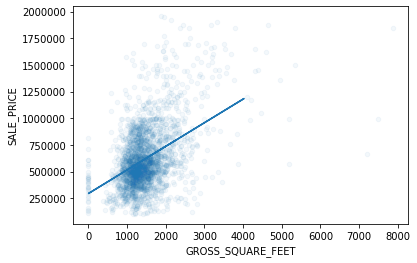

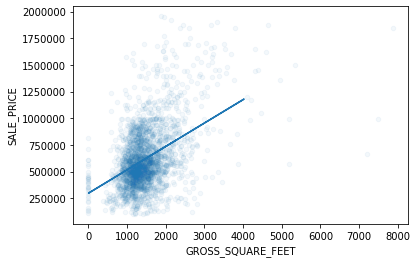

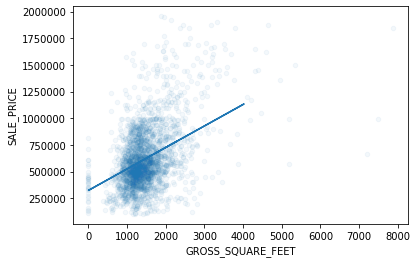

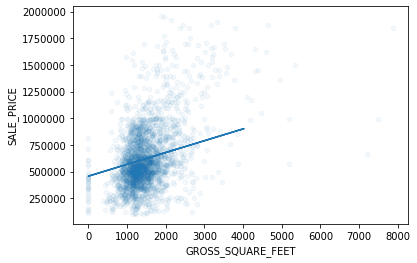

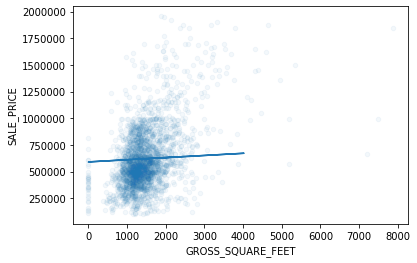

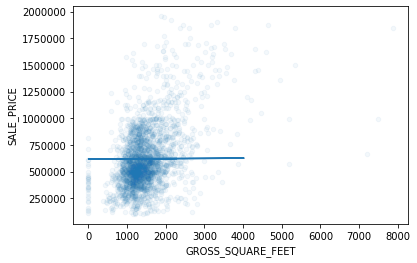

In [46]:
# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'GROSS_SQUARE_FEET'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()

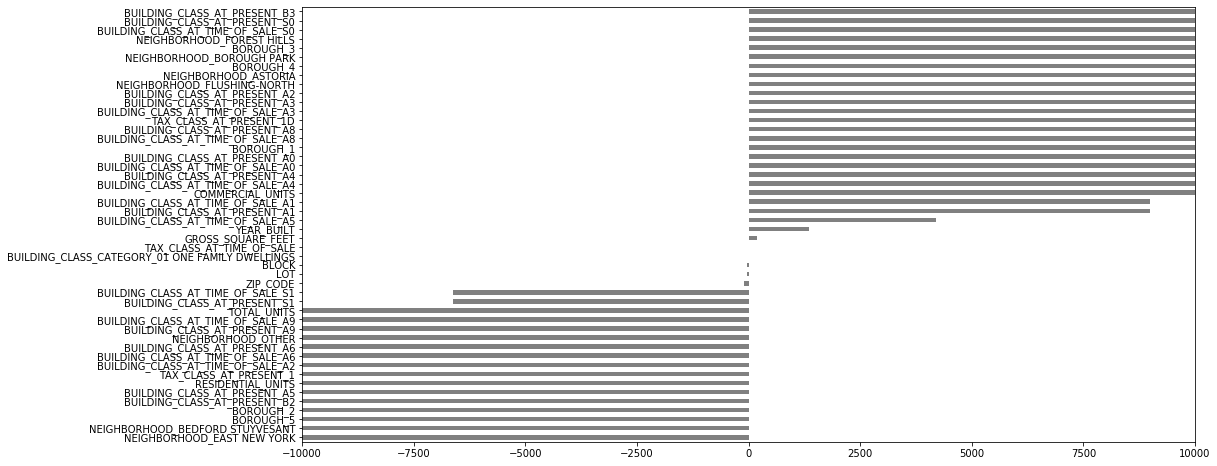

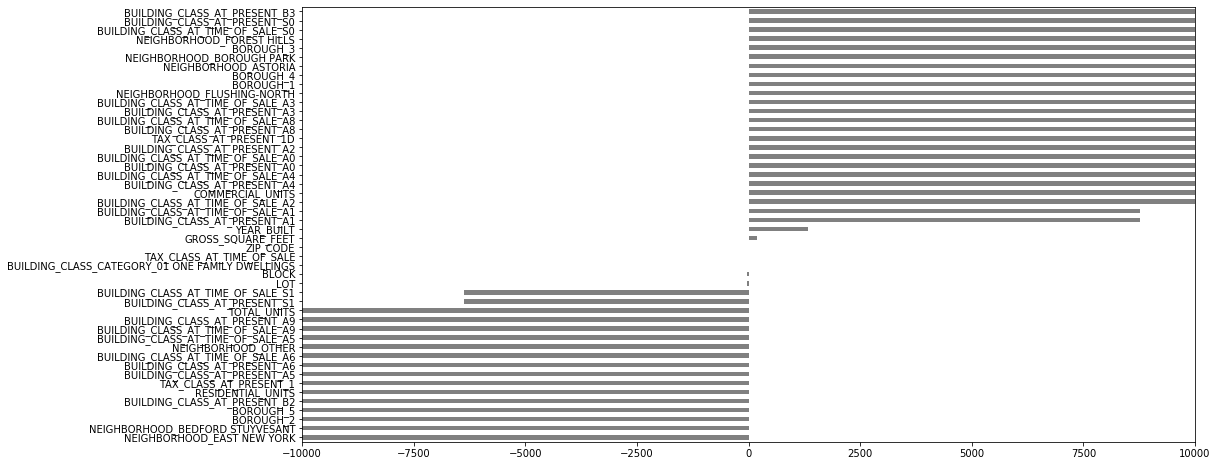

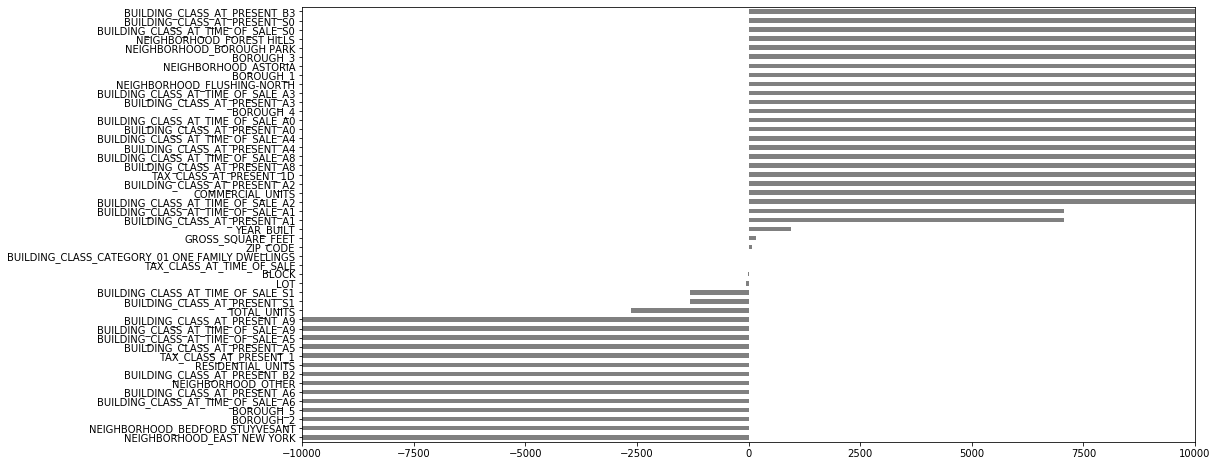

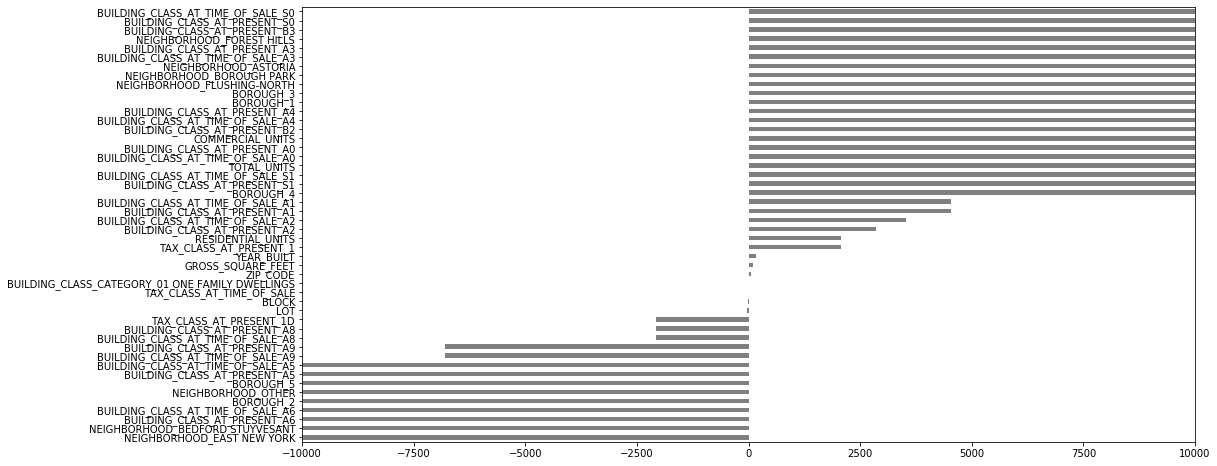

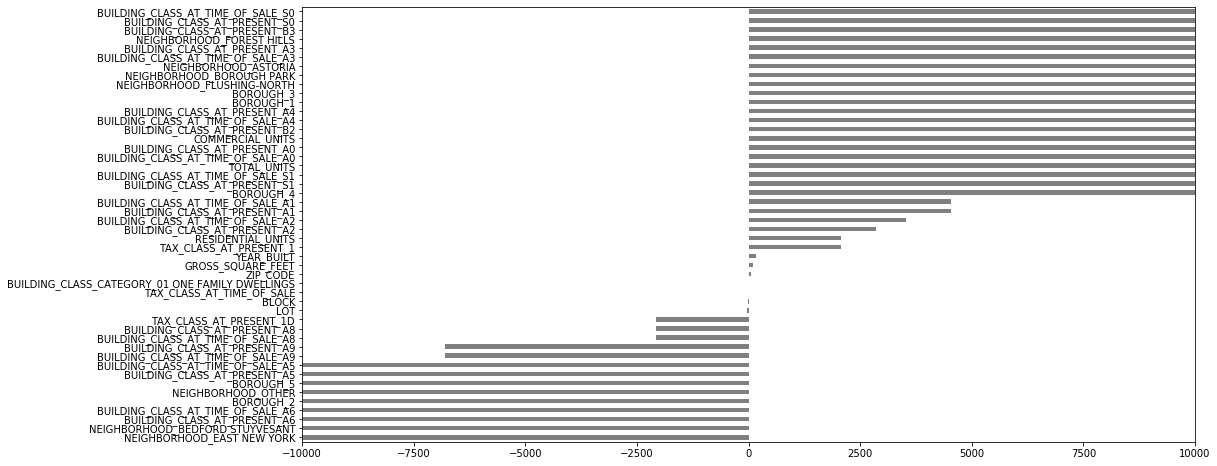

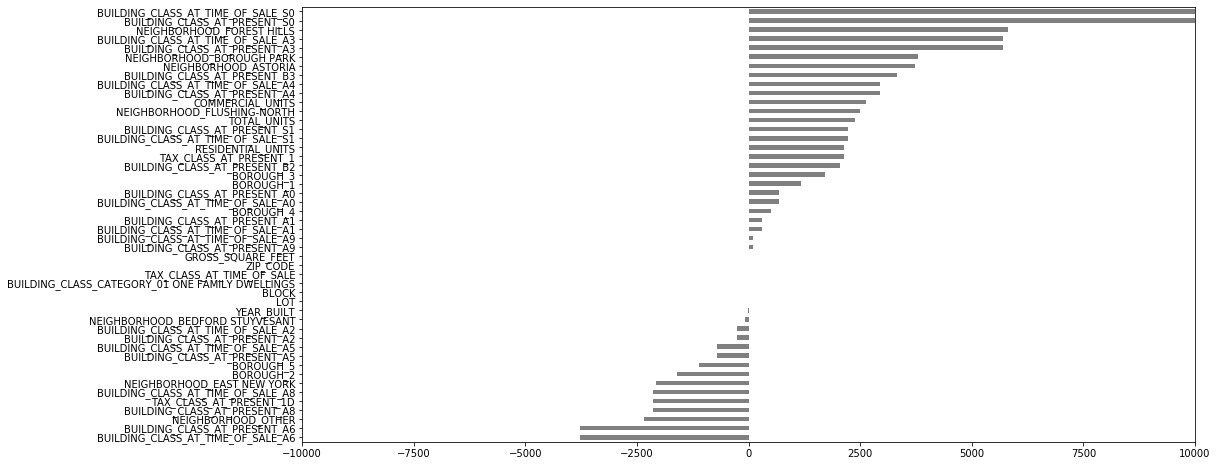

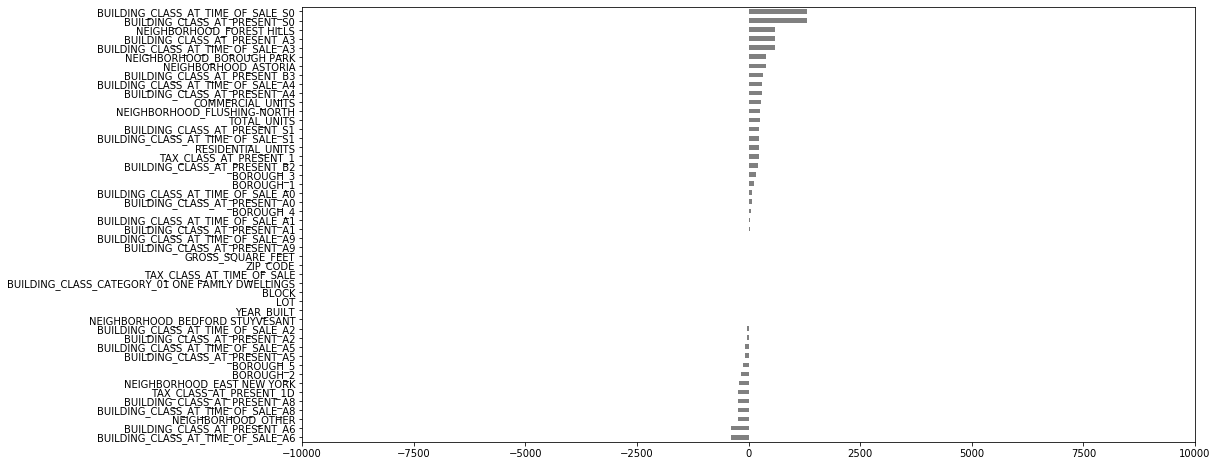

In [47]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-10000,10000)
    plt.show()